In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

DATASET_NAME = "ims_bearings"
DATASET_URL = "https://data.nasa.gov/download/brfb-gzcv/application/zip"
TEMP_PATH = os.path.expanduser('~/Downloads') + "/dataset/"

# Download the dataset to temp
os.system("mkdir -p " + TEMP_PATH)

#check if exists first
ZIPPED = TEMP_PATH + DATASET_NAME + ".zip"
if os.path.exists(ZIPPED):
    print("Dataset already downloaded")
else:
    #unzip it inside its own folder
    os.system("wget -q -O " + ZIPPED + " " + DATASET_URL)
    os.system("unzip " + ZIPPED + " -d " + TEMP_PATH + DATASET_NAME)

Dataset already downloaded


In [2]:
IMS_PATH = TEMP_PATH + DATASET_NAME + "/IMS/"
os.chdir(IMS_PATH)
os.system("ls")

#check if unrar exists
if not os.path.exists("/usr/bin/unrar"):
    print("unrar not installed")
    sys.exit(1)

if not os.path.exists(IMS_PATH + "1/"):
    os.system("mkdir -p " + IMS_PATH + "1/")
    os.system("mkdir -p " + IMS_PATH + "2/")
    os.system("mkdir -p " + IMS_PATH + "3/")

    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/1st_test.rar 1/")
    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/2nd_test.rar 2/")
    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/3rd_test.rar 3/")

1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
ims_bearings_test_exp1_b3_spectrograms.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf


In [86]:
def downsample_nparray(data, factor=2):
    """
    Downsamples a numpy array by a given factor.

    Parameters
    ----------
    data : array_like
        Input data array.
    factor : int
        Factor by which to downsample the data.

    Returns
    -------
    downsampled_data : array_like
        Downsampled data array.
    """
    downsampled_data = data[::factor]
    
    #normalise 
    downsampled_data = downsampled_data - np.mean(downsampled_data)
    downsampled_data = downsampled_data / np.std(downsampled_data)
    
    return downsampled_data
    

def create_windows(data, window_length=128, overlap_length=32, window_type='rectangular'):
    """
    Creates a list of windows from a numpy array.

    Parameters
    ----------
    data : array_like
        Input data array.
    window_length : int
        Length of the window.
    overlap_length : int
        Length of the overlap between windows.

    Returns
    -------
    windows : list
        List of windows.
    """
    windows = []
    for i in range(0, len(data) - window_length, window_length-overlap_length):
        if window_type == 'hamming':
            coeffs = np.hamming(window_length)
        else:
            coeffs = np.ones(window_length)
            
        windows.append(coeffs * data[i:i + window_length].flatten())
    return np.array(windows)
    
def create_stft_spectrogram(windows, fft_length=128):
    """
    Creates a spectrogram from a list of windows.

    Parameters
    ----------
    windows : list
        List of windows.
    fft_length : int
        Length of the FFT.

    Returns
    -------
    spectrogram : array_like
        Spectrogram.
    """
    ft = np.abs(np.fft.fft(windows, n=fft_length, axis=1))**2/2
    ft = ft / np.max(ft)

    spectrogram = np.abs(np.log(ft + 1e-10))
    spectrogram = (spectrogram / np.max(spectrogram) - 0.5)*2
    
    #keep only the last half of the fft (the other half is a mirror image)
    spectrogram = spectrogram[:, :fft_length // 2]
    
    spectrogram = spectrogram.T

    return spectrogram


def create_stft_spectrograms(windows, stft_overlap=10, stft_window_length=50, fft_length=128):
    """
    Creates a list of spectrogram images from a list of all windows. The windows are first grouped into new windows. 
    Those new windows are then used to create the spectrograms.

    Parameters
    ----------
    windows : list
        List of all windows that shall be grouped.
    overlap : int
        Length of the overlap between window groups.
    stft_window_length : int
        Length of the window group for the STFT.

    Returns
    -------
    spectrograms : list
        List of spectrograms.
    """
    spectrograms = []
    for i in range(0, len(windows) - stft_window_length, stft_window_length-stft_overlap):
        #sliding window over the windows by overlap
        current_window = windows[i:i + stft_window_length]
        
        spectrograms.append(create_stft_spectrogram(current_window, fft_length=fft_length))
    return np.array(spectrograms)
    


def convert_nasa_experiments_to_numpy(ims_path=IMS_PATH, limit=1e10):
    experiment_files = {"1": os.listdir(ims_path + "1/"), "2": os.listdir(ims_path + "2/"), "3": os.listdir(ims_path + "3/")}
    experiments_data = {"1": {"bearing3_values":[],"bearing3_keys":[]} , "2": {"bearing3_values":[],"bearing3_keys":[]}, "3": {"bearing3_values":[],"bearing3_keys":[]}}
    
    #sort experiment files by name
    for experiment in experiment_files:
        experiment_files[experiment] = sorted(experiment_files[experiment])
        
    
    for experiment in experiment_files:
        i=0
        for file in experiment_files[experiment]:
            #print("Converting exp %s file %s" % (experiment, file))
            #load the data in the file
            bearing3_channel = 4 if experiment == "1" else 2
            
            data = np.loadtxt(ims_path + experiment + "/" + file)
            vals = data[:,bearing3_channel]
            
            experiments_data[experiment]['bearing3_values'].append(vals)
            experiments_data[experiment]['bearing3_keys'].append(file)
            i+=1
            
            if i > limit:
                break
        
    print("Converting NASA IMS dataset to spectrograms")
    return experiments_data,experiment_files

In [87]:
experiments_data,experiment_files = convert_nasa_experiments_to_numpy()

Converting NASA IMS dataset to spectrograms


### bearing 3 failure labels

from: https://github.com/Miltos-90/Failure_Classification_of_Bearings?tab=readme-ov-file


#### Bearing 3
* early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
* normal: 2003.11.01.21.51.44 - 2003.11.22.09.16.56
* suspect: 2003.11.22.09.26.56 - 2003.11.25.10.47.32
* Inner race failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

Plotting spectrograms
We have 32 spectrograms
Plotting spectrograms
We have 32 spectrograms


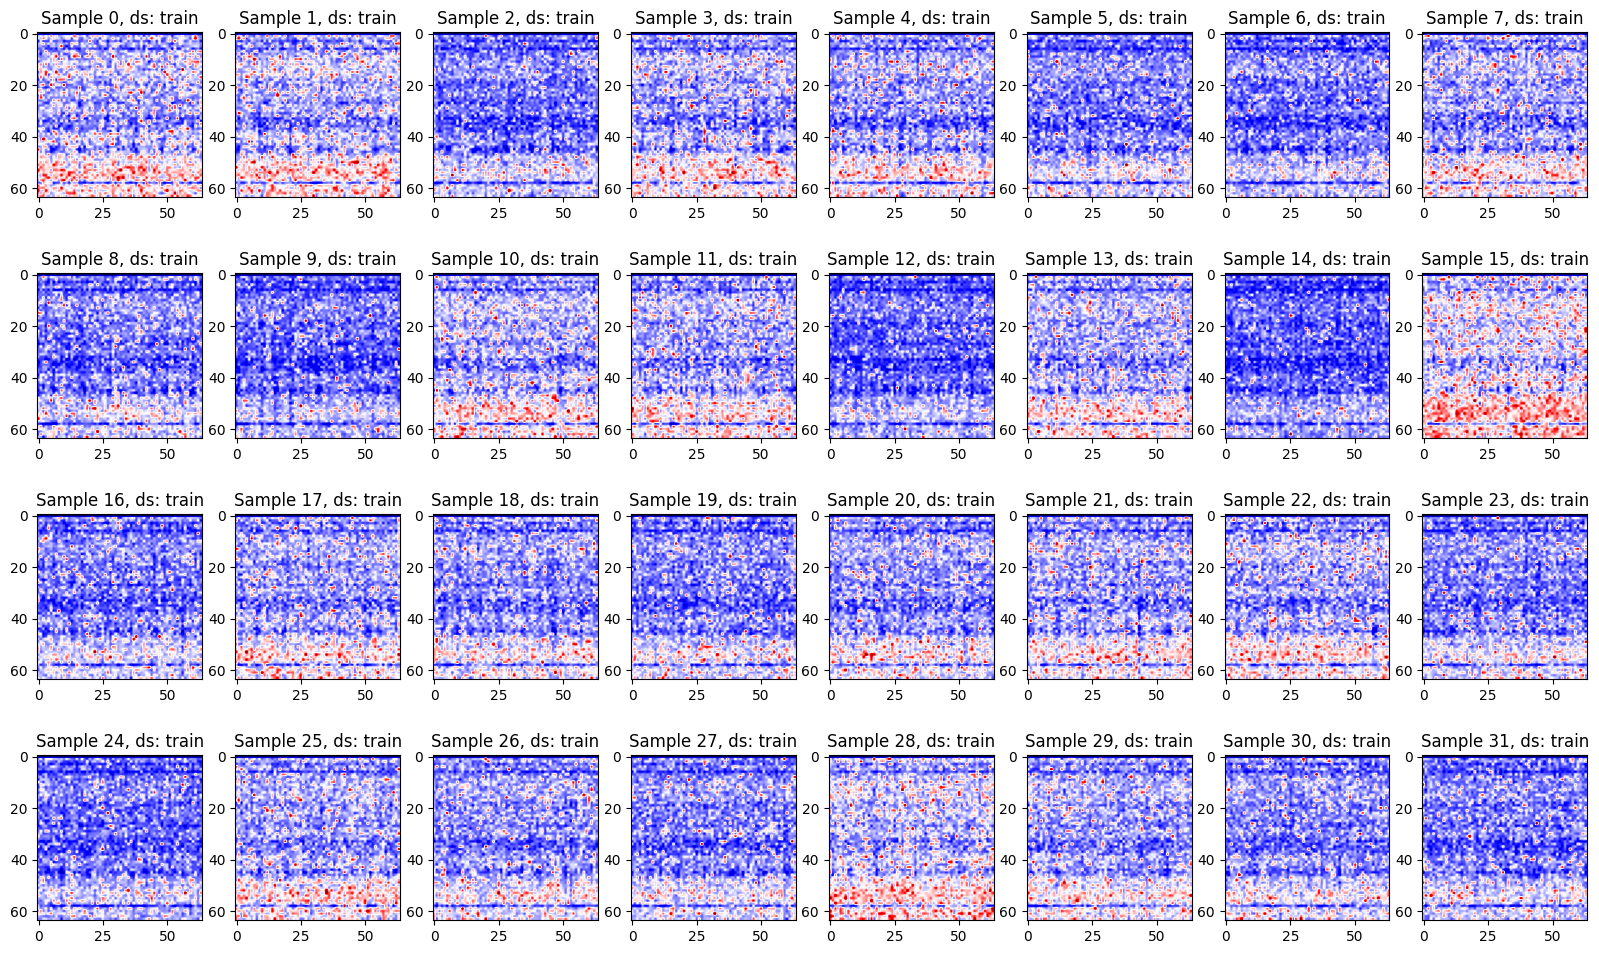

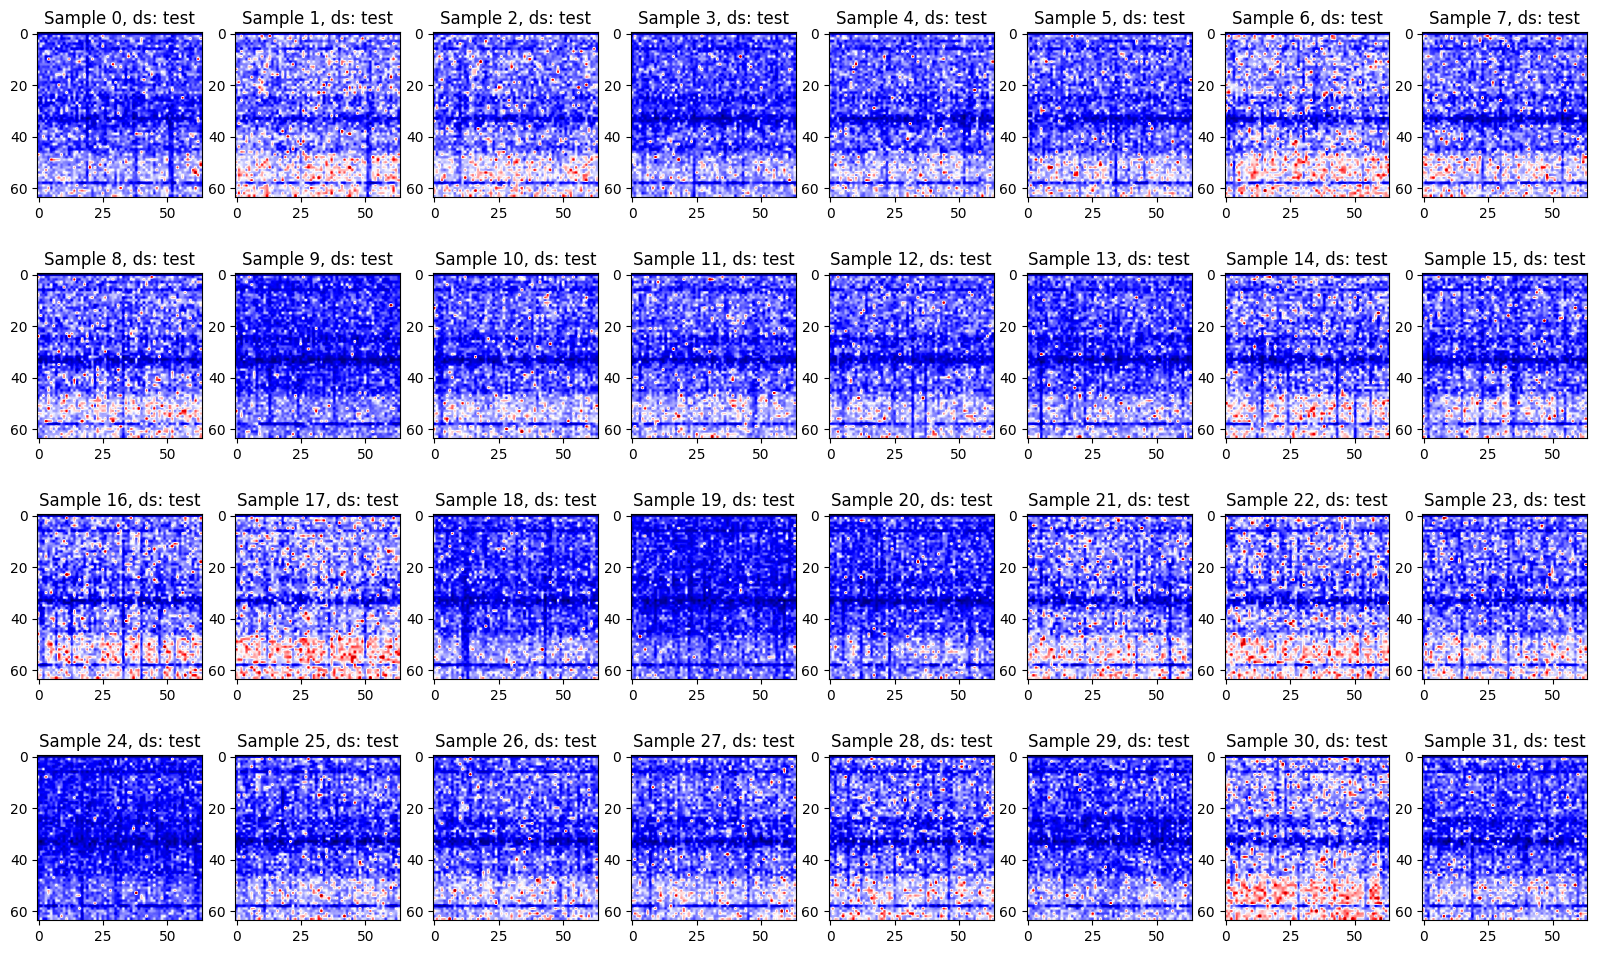

In [88]:
def create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=False, plot=False):

    if startfile.__class__ == str:
        index_start = experiments_data[experiment]['bearing%s_keys'%bearing].index(startfile)
        index_end = experiments_data[experiment]['bearing%s_keys'%bearing].index(endfile)
    else:
        index_start = startfile
        index_end = endfile

    training_files = experiment_files[experiment][index_start:index_end]
    training_data = experiments_data[experiment]['bearing%s_values'%bearing][index_start:index_end]
    training_data = np.stack(training_data) #each row is 1 second of data, taken every 10 minutes

    #generate spectrograms
    all_training_sample_spectrograms = []
    for i in range(0, len(training_data)):
        traiing_sample_window = create_windows(training_data[i], window_type='regular', window_length=256, overlap_length=0)
        training_sample_spectrograms = create_stft_spectrograms(traiing_sample_window, stft_overlap=0, stft_window_length=64, fft_length=128)

        all_training_sample_spectrograms.append(training_sample_spectrograms)
        
        if plot and i > 30:
            break

    #create torch dataset
    all_training_sample_spectrograms = np.vstack(all_training_sample_spectrograms)
    all_training_sample_spectrograms = torch.from_numpy(all_training_sample_spectrograms).float()

    if save:
        print("we have %s normal training samples of %s x %s stft spectrograms" % (all_training_sample_spectrograms.shape[0], all_training_sample_spectrograms.shape[1], all_training_sample_spectrograms.shape[2]))
        #save the dataset
        torch.save(all_training_sample_spectrograms, "%s_%s_exp%s_b%s_spectrograms.pt" % (DATASET_NAME,name,experiment,bearing))
        os.system("ls")
        
    if plot:
        #create subplot 
        fig, axs = plt.subplots(4, 8, figsize=(20, 12))
        print("Plotting spectrograms")
        print("We have %s spectrograms" % all_training_sample_spectrograms.shape[0])
        for i in range(0, all_training_sample_spectrograms.shape[0]):
            axs[i // 8, i % 8].imshow(all_training_sample_spectrograms[i].numpy(), cmap='seismic')
            axs[i // 8, i % 8].set_title("Sample %s, ds: %s" % (i, name))
            
    return all_training_sample_spectrograms

train = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=False, plot=True)
test = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="test", startfile = "2003.11.25.10.57.32", endfile= "2003.11.25.23.39.56", bearing=3, experiment="1", save=False, plot=True)

In [89]:
print(train[0].max(), train[0].min(), train[0].mean())


tensor(0.8188) tensor(-1.) tensor(-0.1781)


In [90]:

train = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=True, plot=False)
test = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="test", startfile = "2003.11.25.10.57.32", endfile= "2003.11.25.23.39.56", bearing=3, experiment="1", save=True, plot=False)

we have 1290 normal training samples of 64 x 64 stft spectrograms
1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
ims_bearings_test_exp1_b3_spectrograms.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf
we have 35 normal training samples of 64 x 64 stft spectrograms
1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
ims_bearings_test_exp1_b3_spectrograms.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf
